In [26]:
import torch
from torchvision.transforms import ToTensor,Compose,Normalize
from torchvision.datasets import MNIST 
import matplotlib.pyplot as plt

In [27]:
mnist = MNIST(root='data', 
              train=True, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

In [28]:
def denorm(x):
    out = (x +1)/2
    return out.clamp(0,1)

In [29]:
img, label = mnist[0]
print('Label: ', label)
torch.min(img), torch.max(img)

Label:  5


(tensor(-1.), tensor(1.))

Label: 5


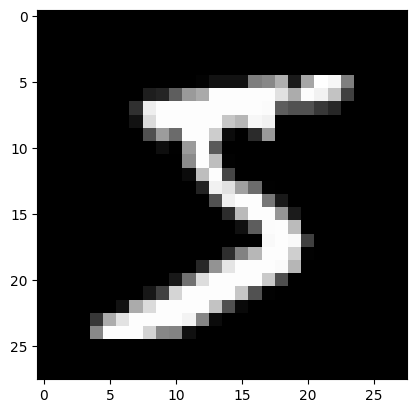

In [30]:
img_norm = img
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

In [31]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

torch.Size([100, 1, 28, 28])
tensor([0, 5, 5, 2, 8, 6, 9, 3, 4, 1, 8, 4, 5, 4, 1, 6, 1, 2, 0, 4, 2, 0, 6, 7,
        1, 2, 2, 0, 6, 5, 3, 4, 5, 0, 8, 3, 2, 4, 6, 7, 7, 5, 2, 0, 6, 3, 6, 9,
        5, 8, 2, 6, 4, 8, 9, 7, 3, 6, 0, 3, 8, 6, 7, 4, 3, 4, 5, 5, 1, 2, 3, 4,
        8, 1, 1, 8, 7, 1, 9, 7, 8, 3, 1, 1, 8, 8, 4, 7, 7, 2, 6, 7, 4, 7, 3, 6,
        7, 1, 8, 6])


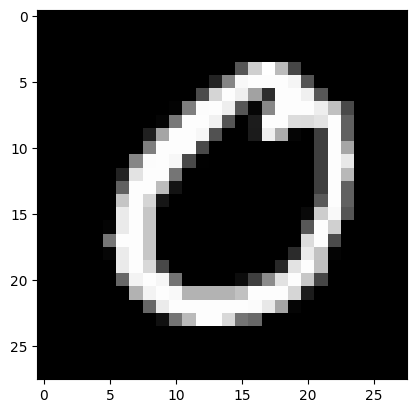

In [32]:
for img_batch, label_batch in data_loader:
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [34]:
device

device(type='cpu')

In [35]:
image_size = 784
hidden_size = 256

In [36]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size,hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size,hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size,1),
    nn.Sigmoid()
)

In [37]:
D.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

In [38]:
latent_size = 64

G = nn.Sequential(
    nn.Linear(latent_size,hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size,hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size,image_size),
    nn.Tanh()
)

In [39]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

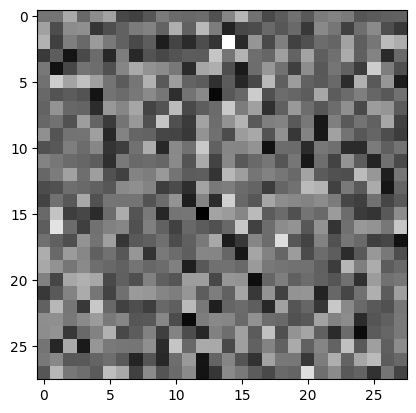

In [40]:
plt.imshow(gen_imgs[0], cmap='gray');

In [41]:
G.to(device)

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

In [42]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [43]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

In [44]:
def train_discriminator(images):
    real_labels = torch.ones(batch_size,1).to(device)
    fake_labels = torch.zeros(batch_size,1).to(device)

    outputs = D(images)
    d_loss_real = criterion(outputs,real_labels)
    real_score = outputs

    z = torch.randn(batch_size,latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs,fake_labels)
    fake_score = outputs

    d_loss = d_loss_real+d_loss_fake

    reset_grad()
    d_loss.backward()
    d_optimizer.step()

    return d_loss,real_score,fake_score

In [45]:
def train_generator():
    z = torch.randn(batch_size,latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size,1).to(device)
    g_loss = criterion(D(fake_images),labels)

    reset_grad()
    g_loss.backward()
    g_optimizer.step()

    return g_loss,fake_images


In [46]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

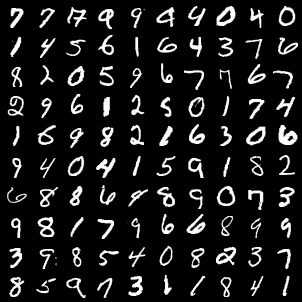

In [47]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


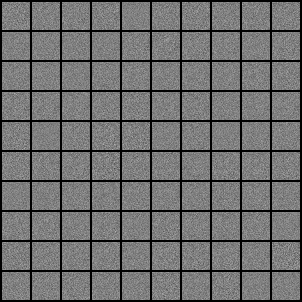

In [48]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [49]:
num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i,(image,label) in enumerate(data_loader):
        images = images.reshape(batch_size,-1).to(device)
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0533, g_loss: 3.8979, D(x): 0.99, D(G(z)): 0.05
Epoch [0/300], Step [400/600], d_loss: 0.0609, g_loss: 5.8088, D(x): 0.99, D(G(z)): 0.04
Epoch [0/300], Step [600/600], d_loss: 0.0305, g_loss: 5.9424, D(x): 0.99, D(G(z)): 0.02
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0096, g_loss: 6.2089, D(x): 1.00, D(G(z)): 0.01
Epoch [1/300], Step [400/600], d_loss: 0.0836, g_loss: 5.3888, D(x): 0.97, D(G(z)): 0.05
Epoch [1/300], Step [600/600], d_loss: 0.0249, g_loss: 5.6803, D(x): 0.99, D(G(z)): 0.02
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.1744, g_loss: 6.7737, D(x): 0.89, D(G(z)): 0.04
Epoch [2/300], Step [400/600], d_loss: 0.2329, g_loss: 5.0329, D(x): 0.87, D(G(z)): 0.05
Epoch [2/300], Step [600/600], d_loss: 0.2446, g_loss: 4.3721, D(x): 0.91, D(G(z)): 0.13
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.2285, g_loss: 3.9840, D(x): 0.89, D(G(z)): 0.07
Epoch [3/300], Step [400/6

KeyboardInterrupt: 

In [ ]:
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')